# Interactive Examples on Project Aria Tools

### Notebook stuck?
Note that because of Jupyter issues, sometimes the code may stuck at visualization. We recommend **restart the kernels** and try again to see if the issue is resolved.

In [1]:
# Specifics for Google Colab
# google_colab_env = 'google.colab' in str(get_ipython())
# if google_colab_env:
#     print("Running from Google Colab, installing projectaria_tools and getting sample data")
#     !pip install projectaria-tools
#     !curl -O -J -L "https://github.com/facebookresearch/projectaria_tools/raw/main/data/mps_sample/sample.vrs"
#     vrsfile = "sample.vrs"
# else:
#     print("Using a pre-existing projectaria_tool github repository")
#     vrsfile = "../../data/mps_sample/sample.vrs"

In [2]:
import sys
import os

# Add the current repository path to sys.path
# repo_path = os.path.abspath(os.path.join(os.getcwd(), '../../'))
# sys.path.insert(0, repo_path)
# print(repo_path)

vrsfile = r"C:\Users\Cooper Lab\projectaria_sandbox\Nymeria_v0.0_20231222_s1_kenneth_fischer_act7_56uvqd_recording_head_data_data.vrs"
print(os.path.exists(vrsfile))  # This should return True

True


In [3]:
from projectaria_tools.core import data_provider, calibration
from projectaria_tools.core.image import InterpolationMethod
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from projectaria_tools.core.stream_id import RecordableTypeId, StreamId
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

## Create data provider

In [4]:
print(f"Creating data provider from {vrsfile}")
provider = data_provider.create_vrs_data_provider(vrsfile)
if not provider:
    print("Invalid vrs data provider")

Creating data provider from C:\Users\Cooper Lab\projectaria_sandbox\Nymeria_v0.0_20231222_s1_kenneth_fischer_act7_56uvqd_recording_head_data_data.vrs


# Retrieving image data

Goals:
- Learn how to retrieve Image data for a given Image stream

Key learnings:
- VRS contains data streams are identified with a Unique Identifier: stream_id
- Learn what are the Stream Ids used by Aria data (Slam, Rgb, EyeTracking)
- Learn that image data can be retrieved by using a record Index or a timestamp
- For each stream_id, index ranges from [0, get_num_data(stream_id)], and the same index for different streams could have different timestamps
- Query data from different sensors of the same timestamp can be done through `get_image_data_by_time_ns`, `get_imu_data_by_time_ns`, etc

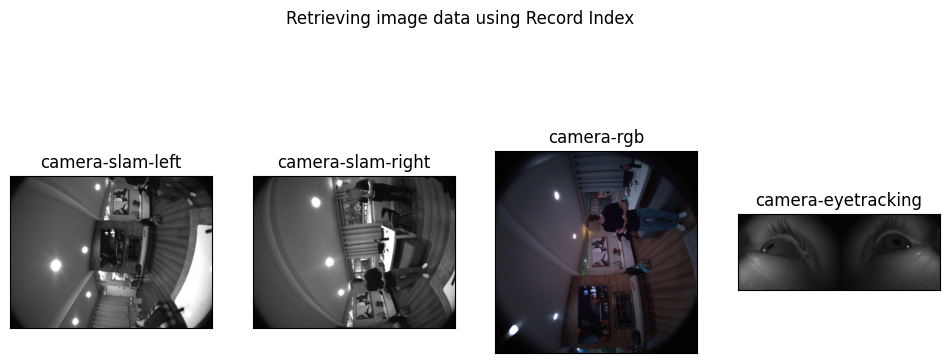

<Figure size 640x480 with 0 Axes>

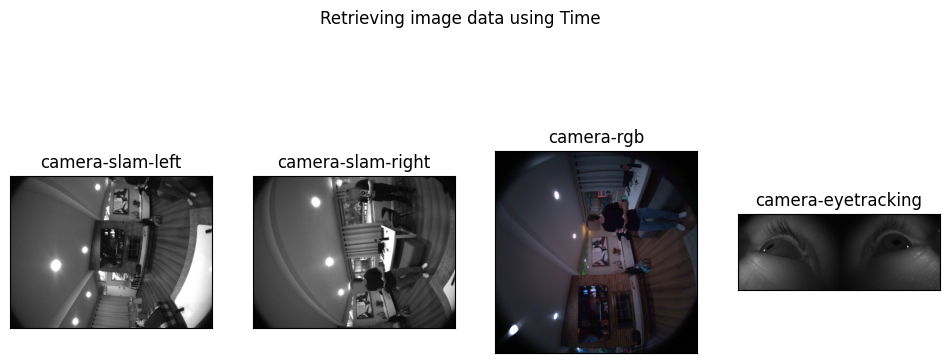

In [5]:
stream_mappings = {
    "camera-slam-left": StreamId("1201-1"),
    "camera-slam-right":StreamId("1201-2"),
    "camera-rgb":StreamId("214-1"),
    "camera-eyetracking":StreamId("211-1"),
}

axes = []
fig, axes = plt.subplots(1, 4, figsize=(12, 5))
fig.suptitle('Retrieving image data using Record Index')

# Query data with index
frame_index = 1
for idx, [stream_name, stream_id] in enumerate(list(stream_mappings.items())):
    image = provider.get_image_data_by_index(stream_id, frame_index)
    axes[idx].imshow(image[0].to_numpy_array(), cmap="gray", vmin=0, vmax=255)
    axes[idx].title.set_text(stream_name)
    axes[idx].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

# Same example using Time
rgb_stream_id = StreamId('214-1')
plt.figure()
fig, axes = plt.subplots(1, 4, figsize=(12, 5))
fig.suptitle('Retrieving image data using Time')

time_domain = TimeDomain.DEVICE_TIME  # query data based on host time
option = TimeQueryOptions.CLOSEST # get data whose time [in TimeDomain] is CLOSEST to query time
start_time = provider.get_first_time_ns(rgb_stream_id, time_domain)

for idx, [stream_name, stream_id] in enumerate(list(stream_mappings.items())):
    image = provider.get_image_data_by_time_ns(stream_id, start_time, time_domain, option)
    axes[idx].imshow(image[0].to_numpy_array(), cmap="gray", vmin=0, vmax=255)
    axes[idx].title.set_text(stream_name)
    axes[idx].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()


# Summarize a VRS using thumbnails

Goals:
- Summarize a VRS using 10 image side by side

Key learnings:
- Image streams are identified with a Unique Identifier: stream_id
- PIL images can be created from Numpy array

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 59.70it/s]


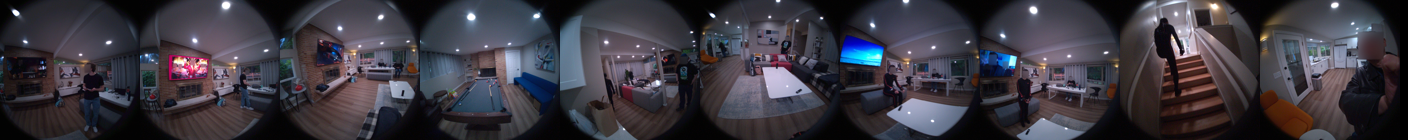

In [6]:
from PIL import Image, ImageOps
from tqdm import tqdm

rgb_stream_id = StreamId("214-1")

# Retrieve Start and End time for the given Sensor Stream Id
start_time = provider.get_first_time_ns(rgb_stream_id, time_domain)
end_time = provider.get_last_time_ns(rgb_stream_id, time_domain)

# Retrieve image size for the RGB stream
time_domain = TimeDomain.DEVICE_TIME  # query data based on host time
option = TimeQueryOptions.CLOSEST # get data whose time [in TimeDomain] is CLOSEST to query time

image_config = provider.get_image_configuration(rgb_stream_id)
width = image_config.image_width
height = image_config.image_height

sample_count = 10
resize_ratio = 10
thumbnail = newImage = Image.new(
    "RGB", (int(width * sample_count / resize_ratio), int(height / resize_ratio))
)
current_width = 0


# Samples 10 timestamps
sample_timestamps = np.linspace(start_time, end_time, sample_count)
for sample in tqdm(sample_timestamps):
    image_tuple = provider.get_image_data_by_time_ns(rgb_stream_id, int(sample), time_domain, option)
    image_array = image_tuple[0].to_numpy_array()
    image = Image.fromarray(image_array)
    new_size = (
        int(image.size[0] / resize_ratio),
        int(image.size[1] / resize_ratio),
    )
    image = image.resize(new_size).rotate(-90)
    thumbnail.paste(image, (current_width, 0))
    current_width = int(current_width + width / resize_ratio)

from IPython.display import Image
display(thumbnail)

# Obtain mapping between stream_id and sensor label
Goals:
- In a vrs file, each sensor data is identified through stream_id
- Learn mapping between stream_id and label for each sensor

Key learnings:
- VRS is using Unique Identifier for each stream called stream_id. 
- For each sensor data, it is attached with a stream_id, which contains two parts [RecordableTypeId, InstanceId]. 
- To get the actual readable name of each sensor,
we can use `get_label_from_stream_id` vise versa `get_stream_id_from_label`

In [7]:
streams = provider.get_all_streams()
for stream_id in streams:
    label = provider.get_label_from_stream_id(stream_id)
    print(
        f"stream_id: [{stream_id}] convert to label: [{label}] and back: [{provider.get_stream_id_from_label(label)}]"
    )

stream_id: [211-1] convert to label: [camera-et] and back: [211-1]
stream_id: [214-1] convert to label: [camera-rgb] and back: [214-1]
stream_id: [247-1] convert to label: [baro0] and back: [247-1]
stream_id: [1201-1] convert to label: [camera-slam-left] and back: [1201-1]
stream_id: [1201-2] convert to label: [camera-slam-right] and back: [1201-2]
stream_id: [1202-1] convert to label: [imu-right] and back: [1202-1]
stream_id: [1202-2] convert to label: [imu-left] and back: [1202-2]
stream_id: [1203-1] convert to label: [mag0] and back: [1203-1]


# Get sensor data in a sequence based on data capture time
Goal:
- Obtain sensor data sequentially based on timestamp

Key learnings
- Default option activates all sensors and playback the entire dataset from vrs
- Setup option to only activate certain streams, truncate start/end time, and sample rate
- Obtain data from different sensor types
- `TimeDomain` are separated into four categories: `RECORD_TIME`, `DEVICE_TIME`, `HOST_TIME`, `TIME_CODE`

### Step 1: obtain default options that provides the whole dataset from VRS
* activates all sensor streams
* No truncation for first/last timestamp
* Subsample rate = 1 (do not skip any data per sensor)

In [8]:
options = (
    provider.get_default_deliver_queued_options()
)  # default options activates all streams

### Step 2: set preferred deliver options
* truncate first/last time: `set_truncate_first_device_time_ns/set_truncate_last_device_time_ns()`
* subselect sensor streams to play: `activate_stream(stream_id)`
* skip sensor data : `set_subsample_rate(stream_id, rate)`

In [9]:
options.set_truncate_first_device_time_ns(int(1e8))  # 0.1 secs after vrs first timestamp
options.set_truncate_last_device_time_ns(int(1e9))  # 1 sec before vrs last timestamp

# deactivate all sensors
options.deactivate_stream_all()
# activate only a subset of sensors
slam_stream_ids = options.get_stream_ids(RecordableTypeId.SLAM_CAMERA_DATA)
imu_stream_ids = options.get_stream_ids(RecordableTypeId.SLAM_IMU_DATA)

for stream_id in slam_stream_ids:
    options.activate_stream(stream_id)  # activate slam cameras
    options.set_subsample_rate(stream_id, 100000)  # sample every 1000th data for each slam camera

for stream_id in imu_stream_ids:
    options.activate_stream(stream_id)  # activate imus
    options.set_subsample_rate(stream_id, 1000000)  # sample every 10000th data for each imu

### Step 3: create iterator to deliver data
`TimeDomain` contains the following
* `RECORD_TIME`: timestamp stored in vrs index, fast to access, but not guaranteed which time domain
* `DEVICE_TIME`: capture time in device's timedomain, accurate
* `HOST_TIME`: arrival time in host computer's timedomain, may not be accurate
* `TIME_CODE`: capture in TimeSync server's timedomain


In [10]:
iterator = provider.deliver_queued_sensor_data(options)
for sensor_data in iterator:
    label = provider.get_label_from_stream_id(sensor_data.stream_id())
    sensor_type = sensor_data.sensor_data_type()
    device_timestamp = sensor_data.get_time_ns(TimeDomain.DEVICE_TIME)
    host_timestamp = sensor_data.get_time_ns(TimeDomain.HOST_TIME)
    timecode_timestamp = sensor_data.get_time_ns(TimeDomain.TIME_CODE)
    print(
        f"""obtain data from {label} of type {sensor_type} with \n
        DEVICE_TIME: {device_timestamp} nanoseconds \n
        HOST_TIME: {host_timestamp} nanoseconds \n
        """
    )

obtain data from imu-right of type SensorDataType.IMU with 

        DEVICE_TIME: 17238478352525 nanoseconds 

        HOST_TIME: 17238486474203 nanoseconds 

        
obtain data from imu-left of type SensorDataType.IMU with 

        DEVICE_TIME: 17238479093187 nanoseconds 

        HOST_TIME: 17238486530869 nanoseconds 

        
obtain data from camera-slam-right of type SensorDataType.IMAGE with 

        DEVICE_TIME: 17238480260437 nanoseconds 

        HOST_TIME: 17238492506659 nanoseconds 

        
obtain data from camera-slam-left of type SensorDataType.IMAGE with 

        DEVICE_TIME: 17238480260450 nanoseconds 

        HOST_TIME: 17238492128690 nanoseconds 

        
obtain data from imu-right of type SensorDataType.IMU with 

        DEVICE_TIME: 18236722903775 nanoseconds 

        HOST_TIME: 18236730169603 nanoseconds 

        


# Random access data
Goal
- Access data from a stream randomly using a data index or a timestamp

Key learnings
- Sensor data can be obtained through index within the range of [0, number of data for this stream_id)

  - `get_sensor_data_by_index(stream_id, index)`
  - `get_image_data_by_index(stream_id, index)`
  - Access other sensor data by index interface is available in core/python/VrsDataProviderPyBind.h
  
- `TimeQueryOptions` has three options: `TimeQueryOptions.BEFORE`, `TimeQueryOptions.AFTER`, `TimeQueryOptions.CLOSEST`
- Query through index will provide the exact data vs query through a timestamp that is not exact, data nearby will be omitted base on `TimeQueryOptions`

In [11]:
sensor_name = "camera-slam-right"
sensor_stream_id = provider.get_stream_id_from_label(sensor_name)

# get all image data by index
num_data = provider.get_num_data(sensor_stream_id) 
#print(num_data) returns 31408 for ken ken
sub_num_data = num_data // 310 #if you leave it as a float it gets mad, this returns 101
# print(sub_num_data)

for index in range(0, sub_num_data): #returns the first 100
    image_data = provider.get_image_data_by_index(sensor_stream_id, index)
    print(
        f"Get image: {index} with timestamp {image_data[1].capture_timestamp_ns}"
    )

Get image: 0 with timestamp 17238413604437
Get image: 1 with timestamp 17238446932437
Get image: 2 with timestamp 17238480260437
Get image: 3 with timestamp 17238513588437
Get image: 4 with timestamp 17238546916437
Get image: 5 with timestamp 17238580244437
Get image: 6 with timestamp 17238613572437
Get image: 7 with timestamp 17238646900437
Get image: 8 with timestamp 17238680228437
Get image: 9 with timestamp 17238713556437
Get image: 10 with timestamp 17238746884437
Get image: 11 with timestamp 17238780212437
Get image: 12 with timestamp 17238813540437
Get image: 13 with timestamp 17238846868437
Get image: 14 with timestamp 17238880196437
Get image: 15 with timestamp 17238913524437
Get image: 16 with timestamp 17238946852437
Get image: 17 with timestamp 17238980180437
Get image: 18 with timestamp 17239013508437
Get image: 19 with timestamp 17239046836437
Get image: 20 with timestamp 17239080164437
Get image: 21 with timestamp 17239113492437
Get image: 22 with timestamp 1723914682043

### Sensor data can be obtained by timestamp (nanoseconds)
* Get stream time range `get_first_time_ns` and `get_last_time_ns`
* Specify timedomain: `TimeDomain.DEVICE_TIME` (default)
* Query data by queryTime
  * `TimeQueryOptions.BEFORE` (default): sensor_dataTime <= queryTime
  * `TimeQueryOptions.AFTER` : sensor_dataTime >= queryTime
  * `TimeQueryOptions.CLOSEST` : sensor_dataTime closest to queryTime

In [12]:
time_domain = TimeDomain.DEVICE_TIME  # query data based on DEVICE_TIME
option = TimeQueryOptions.CLOSEST # get data whose time [in TimeDomain] is CLOSEST to query time

start_time = provider.get_first_time_ns(sensor_stream_id, time_domain)
end_time = provider.get_last_time_ns(sensor_stream_id, time_domain)

# print(start_time)
# print(end_time)
diff = end_time - start_time
# print(diff)
diffthong = diff // int(1e9)
#print(diffthong) # returns 1046

# for time in range(start_time, end_time, int(1e7)): #sets step value as int(1e7)
for time in range(diffthong): 
    image_data = provider.get_image_data_by_time_ns(
        sensor_stream_id, time, time_domain, option
    )
    print(
        f"query time {time} and get capture image time {image_data[1].capture_timestamp_ns} within range {start_time} {end_time}"
    )

query time 0 and get capture image time 17238413604437 within range 17238413604437 18285212756437
query time 1 and get capture image time 17238413604437 within range 17238413604437 18285212756437
query time 2 and get capture image time 17238413604437 within range 17238413604437 18285212756437
query time 3 and get capture image time 17238413604437 within range 17238413604437 18285212756437
query time 4 and get capture image time 17238413604437 within range 17238413604437 18285212756437
query time 5 and get capture image time 17238413604437 within range 17238413604437 18285212756437
query time 6 and get capture image time 17238413604437 within range 17238413604437 18285212756437
query time 7 and get capture image time 17238413604437 within range 17238413604437 18285212756437
query time 8 and get capture image time 17238413604437 within range 17238413604437 18285212756437
query time 9 and get capture image time 17238413604437 within range 17238413604437 18285212756437
query time 10 and ge

### Get sensor data configuration

In [13]:
def image_config_example(config):
    print(f"device_type {config.device_type}")
    print(f"device_version {config.device_version}")
    print(f"device_serial {config.device_serial}")
    print(f"sensor_serial {config.sensor_serial}")
    print(f"nominal_rate_hz {config.nominal_rate_hz}")
    print(f"image_width {config.image_width}")
    print(f"image_height {config.image_height}")
    print(f"pixel_format {config.pixel_format}")
    print(f"gamma_factor {config.gamma_factor}")

In [14]:
config = provider.get_image_configuration(provider.get_stream_id_from_label("camera-slam-right"))
image_config_example(config)

device_type Ariane
device_version 49657350001300070
device_serial 1WM103500L1323
sensor_serial 0072510f1b21070108000013091c0001
nominal_rate_hz 30.0
image_width 640
image_height 480
pixel_format 0
gamma_factor 1.0


# Calibration examples
Goal:
- Obtain camera extrinsics and intrinsics
- Learn to project a 3D point to camera frame

Key learnings
- Get calibration for different sensors using sensor labels
- Learn how to use extrinsics/intrinsics to project a 3D points to a given camera
- Reference frame convention

In [15]:
device_calib = provider.get_device_calibration()
all_sensor_labels = device_calib.get_all_labels()
print(f"device calibration contains calibrations for the following sensors \n {all_sensor_labels}")

device calibration contains calibrations for the following sensors 
 ['baro0', 'camera-et-left', 'camera-et-right', 'camera-rgb', 'camera-slam-left', 'camera-slam-right', 'imu-left', 'imu-right', 'mag0', 'mic0', 'mic1', 'mic2', 'mic3', 'mic4', 'mic5', 'mic6']


### Project a 3D point to camera frame

In this section we will learn how to retrieve calibration data and how to use it.
Aria calibration is defined by two objects: one defining the intrinsics (`rgb_calib.project` and `rgb_calib.unproject`) and one defining the extrinsics as a SE3 pose (`device_calib.get_transform_device_sensor(sensor_label`).

Intrinsics can be used to project a 3d point to the image plane or un-project a 2d point as a bearing vector. Extrinsics are used to set the camera in world coordinates at a given rotation and position in space.

### Reference frame convention

> `transform_sensor1_sensor3` = `transform_sensor1_sensor2` * `transform_sensor2_sensor3` \
> `point_in_sensor`: 3D point measured from sensor's reference frame \
> `point_in_sensor` = `transform_sensor1_sensor` * `point_in_sensor`

Device Frame: `device_calib.get_origin_label() = camera-slam-left`\
Sensor extrinsics: `device_calib.get_transform_device_sensor(sensor_label)`

In [16]:
camera_name = "camera-rgb"
transform_device_camera = device_calib.get_transform_device_sensor(camera_name).to_matrix()
transform_camera_device = np.linalg.inv(transform_device_camera)
print(f"Device calibration origin label {device_calib.get_origin_label()}")
print(f"{camera_name} has extrinsics of \n {transform_device_camera}")

rgb_calib = device_calib.get_camera_calib("camera-rgb")
if rgb_calib is not None:
    # project a 3D point in device frame [camera-slam-left] to rgb camera
    point_in_device = np.array([0, 0, 10])
    point_in_camera = (
        np.matmul(transform_camera_device[0:3,0:3], point_in_device.transpose())
        + transform_camera_device[0:3,3]
    )

    maybe_pixel = rgb_calib.project(point_in_camera)
    if maybe_pixel is not None:
        print(
            f"Get pixel {maybe_pixel} within image of size {rgb_calib.get_image_size()}"
        )

Device calibration origin label camera-slam-left
camera-rgb has extrinsics of 
 [[ 0.99428807 -0.04754243  0.09555601 -0.00444305]
 [ 0.09728681  0.7719075  -0.62824684 -0.01199101]
 [-0.04389202  0.63395468  0.77212366 -0.00518403]
 [ 0.          0.          0.          1.        ]]
Get pixel [ 678.09986638 1179.6996885 ] within image of size [1408 1408]


### Get calibration data for other sensors
Aria is a multimodal capture device, each sensors calibration can be retrieved using the same interface. Only EyeTracking (`get_aria_et_camera_calib()`) and Audio calibration (`get_aria_microphone_calib()`) is a bit different since we have multiple sensors that share the same stream_id.

In [17]:
et_calib = device_calib.get_aria_et_camera_calib()
if et_calib is not None:
    print(f"Camera {et_calib[0].get_label()} has image size {et_calib[0].get_image_size()}")
    print(f"Camera {et_calib[1].get_label()} has image size {et_calib[1].get_image_size()}")

imu_calib = device_calib.get_imu_calib("imu-left")
if imu_calib is not None:
    print(f"{imu_calib.get_label()} has extrinsics transform_Device_Imu:\n {imu_calib.get_transform_device_imu().to_matrix3x4()}")

Camera camera-et-left has image size [320 240]
Camera camera-et-right has image size [320 240]
imu-left has extrinsics transform_Device_Imu:
 [[-5.35549493e-03  9.95924007e-01 -9.00371668e-02  7.34664404e-04]
 [ 9.99976125e-01  4.94051982e-03 -4.83116896e-03 -5.32255390e-04]
 [-4.36664674e-03 -9.00608905e-02 -9.95926688e-01 -6.60965877e-03]]


### Undistort an image
You can remove distortions in an image in three steps. 

First, use the provider to access the image and the camera calibration of the stream. Then create a "linear" spherical camera model with `get_spherical_camera_calibration`. The function allows you to specify the image size as well as focal length of the model, assuming principal point is at the image center. Finally, apply `distort_by_calibration` function to distort the image.

<Figure size 640x480 with 0 Axes>

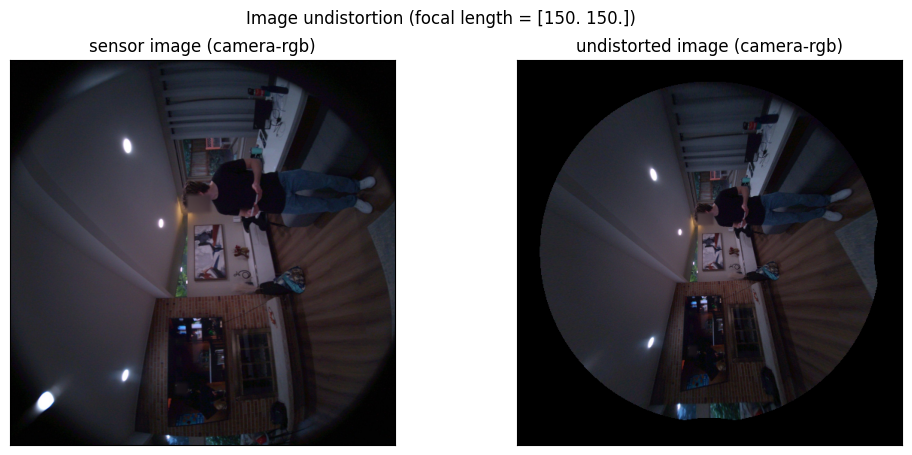

In [18]:
# input: retrieve image as a numpy array
sensor_name = "camera-rgb"
sensor_stream_id = provider.get_stream_id_from_label(sensor_name)
image_data = provider.get_image_data_by_index(sensor_stream_id, 0)
image_array = image_data[0].to_numpy_array()
# input: retrieve image distortion
device_calib = provider.get_device_calibration()
src_calib = device_calib.get_camera_calib(sensor_name)

# create output calibration: a linear model of image size 512x512 and focal length 150
# Invisible pixels are shown as black.
dst_calib = calibration.get_linear_camera_calibration(512, 512, 150, camera_name)

# distort image
rectified_array = calibration.distort_by_calibration(image_array, dst_calib, src_calib, InterpolationMethod.BILINEAR)

# visualize input and results
plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"Image undistortion (focal length = {dst_calib.get_focal_lengths()})")

axes[0].imshow(image_array, cmap="gray", vmin=0, vmax=255)
axes[0].title.set_text(f"sensor image ({sensor_name})")
axes[0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
axes[1].imshow(rectified_array, cmap="gray", vmin=0, vmax=255)
axes[1].title.set_text(f"undistorted image ({sensor_name})")
axes[1].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

Note the rectified image shows a circular area of visible pixels. If you want the entire rectified image to be covered by pixels, you can increase the magnification.

# Correcting Color Distortion in Older Aria Captures
Videos and images captured with earlier versions of the Aria OS may exhibit color distortion due to inconsistent gamma curves and unconventional color temperatures. This can result in colors appearing inconsistent across images and overly blue.
This issue has been resolved in the new OS update V1.13. For images and videos captured before this update, we offer a Color Correction API to address the distortion. The images will be corrected to a reference color temperature of 5000K. 

Below, we demonstrate how to apply color correction: 
1. set `set_color_correction` with True, default value is False
2. The output from `provider.get_image_data_by_index` would be color corrected. 

In [19]:
# save source image for comparison
stream_id = provider.get_stream_id_from_label("camera-rgb")
provider.set_color_correction(False)
provider.set_devignetting(False) 
src_image_array = provider.get_image_data_by_index(stream_id, 0)[0].to_numpy_array()

<Figure size 640x480 with 0 Axes>

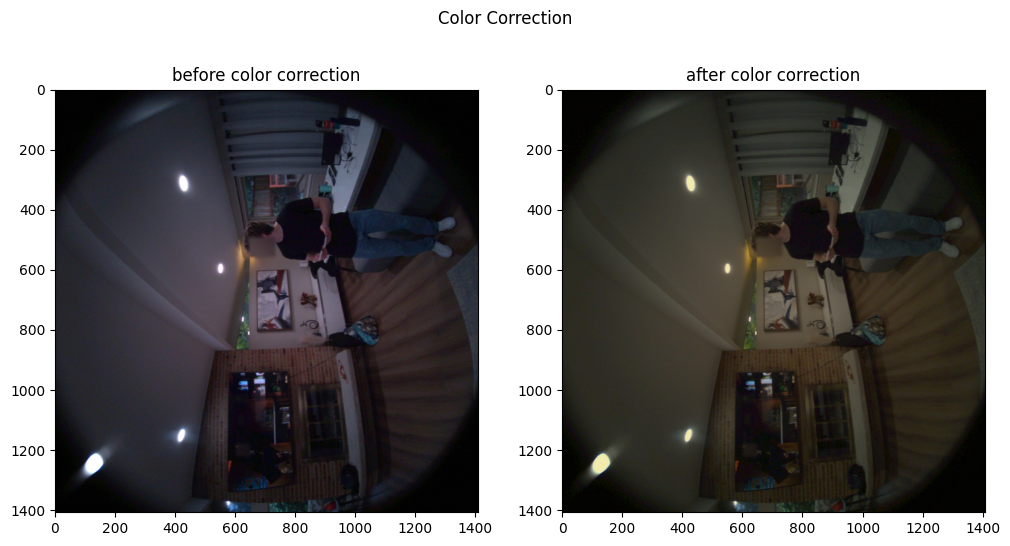

In [20]:
provider.set_color_correction(True) 
provider.set_devignetting(False) 
color_corrected_image_array = provider.get_image_data_by_index(stream_id, 0)[0].to_numpy_array()

# visualize input and results
plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(f"Color Correction")

axes[0].imshow(src_image_array, vmin=0, vmax=255)
axes[0].title.set_text(f"before color correction")
axes[1].imshow(color_corrected_image_array, vmin=0, vmax=255)
axes[1].title.set_text(f"after color correction")

plt.show()

# Devignetting

Devignetting corrects uneven lighting, enhancing image uniformity and clarity. We provide devignetting for camera-rgb full size image [2880, 2880], camera-rgb half size image[1408, 1408] and slam image [640, 480].
1. Aria devignetting masks can be downloaded from [Link](https://www.projectaria.com/async/sample/download/?bucket=core&filename=devignetting_masks_bin.zip). It contains the following files:

```
devignetting_masks_bin
|- new_isp
   |- slam_devignetting_mask.bin
   |- rgb_half_devignetting_mask.bin
   |- rgb_full_devignetting_mask.bin
|- old_isp
   |- slam_devignetting_mask.bin
   |- rgb_half_devignetting_mask.bin
   |- rgb_full_devignetting_mask.bin
```
2. Turn on devignetting. Set devignetting mask folder path with the local aria camera devignetting masks folder path.
   `set_devignetting(True)`
   `mask_folder_path = "devignetting_masks_bin"`
   `set_devignetting_mask_folder_path(mask_folder_path)`
3. The image data from `get_image_data_by_index` will be devignetted. 
4. (Optional) If you don't want to devignetting feature, turn off by calling `set_devignetting(False)`

## Step 1: Download devignetting mask

In [21]:
from urllib.request import urlretrieve
import zipfile
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Download from url
devignetting_mask_folder_path = os.path.join(repo_path, "devignetting_masks")
downloaded_devignetting_mask_zip = os.path.join(devignetting_mask_folder_path, "aria_camera_devignetting_masks.zip")
if not os.path.exists(devignetting_mask_folder_path):
    os.mkdir(devignetting_mask_folder_path)
urlretrieve("https://www.projectaria.com/async/sample/download/?bucket=core&filename=devignetting_masks_bin.zip", downloaded_devignetting_mask_zip)

# unzip the mask files, with cross-platform compatibility
with zipfile.ZipFile(downloaded_devignetting_mask_zip, 'r') as zip_ref:
    # Extract all files
    zip_ref.extractall(devignetting_mask_folder_path)

    # Print out the filenames
    print(f"Successfully downloaded and extracted the following files for devignetting:")
    for file_info in zip_ref.infolist():
        print(file_info.filename)


NameError: name 'repo_path' is not defined

## Step 2: Turn on devignetting and set devignetting mask folder path

In [ ]:
src_image_array = provider.get_image_data_by_index(stream_id, 0)[0].to_numpy_array()
provider.set_devignetting(True)
provider.set_devignetting_mask_folder_path(devignetting_mask_folder_path)

## Step 3: Retrieve Image from stream

In [ ]:
devignetted_image_array = provider.get_image_data_by_index(stream_id, 0)[0].to_numpy_array()

# visualize input and results
plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(f"Image devignetting (camera-rgb)")

axes[0].imshow(src_image_array, vmin=0, vmax=255)
axes[0].title.set_text(f"before devignetting")
axes[1].imshow(devignetted_image_array, vmin=0, vmax=255)
axes[1].title.set_text(f"after devignetting")

plt.show()